In [1]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def D(p, z):
    z = z.detach() # we don't backpropagate here
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return -(p*z).sum(dim=1).mean()

In [3]:
class ProjectionMLP(nn.Module):
    """Projection MLP f"""
    def __init__(self, in_features, h1_features, h2_features, out_features):
        super(ProjectionMLP, self).__init__()
        self.l1 = nn.Sequential(
            nn.Linear(in_features, h1_features),
            nn.BatchNorm1d(h1_features),
            nn.ReLU(inplace=True)
        )
        self.l2 = nn.Sequential(
            nn.Linear(h1_features, h2_features),
            nn.BatchNorm1d(h2_features),
            nn.ReLU(inplace=True)

        )
        self.l3 = nn.Sequential(
            nn.Linear(h2_features, out_features),
            nn.BatchNorm1d(out_features)
        )

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x


In [4]:
class PredictionMLP(nn.Module):
    """Prediction MLP h"""
    def __init__(self, in_features, hidden_features, out_features):
        super(PredictionMLP, self).__init__()
        self.l1 = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.BatchNorm1d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.l2 = nn.Linear(hidden_features, out_features)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

In [5]:
class SimSiam(nn.Module):
    def __init__(self):
        super(SimSiam, self).__init__()
        backbone = resnet18(weights=True) # TODO: Should weights be pretrained?
        num_ftrs = backbone.fc.in_features
        
        self.model = nn.Sequential(*list(backbone.children())[:-1])
        self.projection = ProjectionMLP(num_ftrs, 2048, 2048, 2048)
        self.prediction = PredictionMLP(2048, 512, 2048)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1) # TODO
        z = self.projection(x)
        p = self.prediction(z)
        return z, p
        

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # ((mean, mean, mean), (std, std, st))

In [7]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


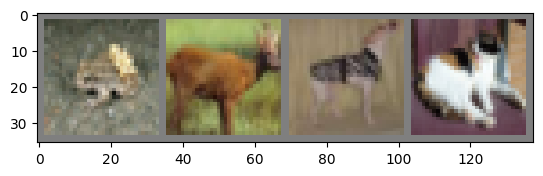

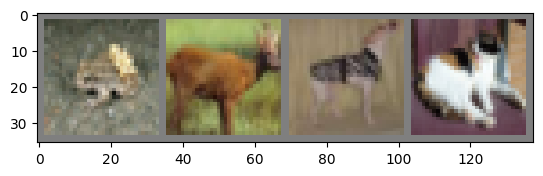

In [8]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def random_aug(image):
    augmentations =["colorjitter", "randomhorizontalflip", "randomcrop", "randomgrayscale"]

    augmentation = np.random.choice(augmentations)

    if augmentation == "randomhorizontalflip":
        transform = transforms.RandomHorizontalFlip(1)
    elif augmentation == "randomcrop":
        transform = transforms.RandomCrop(20)
    elif augmentation == "randomgrayscale":
        transform = transforms.RandomGrayscale(0.2)
    elif augmentation == "colorjitter":
        transform = transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8)

    augmented_img = transform(image)
    return augmented_img


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

# random augmentation
flipped_images = random_aug(images)
imshow(torchvision.utils.make_grid(flipped_images))


In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = SimSiam()
model = model.to(device)

/home/jonas/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/jonas/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# criterion = nn.CrossEntropyLoss() # Got our own loss
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0005)

In [11]:
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):            
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # random augmentations:
        x1 = random_aug(images)
        x2 = random_aug(images)
        
        # forward + backward + optimize
        z1, p1 = model(x1)
        z2, p2 = model(x2)
        #loss = criterion(outputs, labels)
        loss = D(p1, z2)/2 + D(p2, z1)/2
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

KeyboardInterrupt: 

In [ ]:
# knn test accuracy

with torch.no_grad():
    true_predicted = 0
    total_predicted = 0
    for i, data in enumerate(testloader):  
        images, labels = data[0].to(device), data[1].to(device)
        z, _ = model(images) # f(z)
        for j in range(len(images)): # iterate through images
            dist = torch.norm(z[j] - z, dim=1, p=None)
            knn = dist.topk(4, largest=False) # NOTE: Remove first one, it's distance to itself
            # get index
            indices = knn.indices[1:]
            # get label of element at index
            classes = labels[indices]
            # maximum vote
            predicted_label, _ = torch.mode(classes)
            true_label = labels[j]
            if true_label == predicted_label:
                true_predicted += 1
            total_predicted += 1
        print("current accuracy: ", true_predicted/total_predicted)

print("accuracy = ", true_predicted/total_predicted)

current accuracy:  0.0
current accuracy:  0.375
current accuracy:  0.25
current accuracy:  0.1875
current accuracy:  0.15
current accuracy:  0.125
current accuracy:  0.10714285714285714
current accuracy:  0.09375
current accuracy:  0.08333333333333333
current accuracy:  0.075
current accuracy:  0.06818181818181818
current accuracy:  0.0625
current accuracy:  0.057692307692307696
current accuracy:  0.05357142857142857
current accuracy:  0.05
current accuracy:  0.078125
current accuracy:  0.07352941176470588
current accuracy:  0.06944444444444445
current accuracy:  0.06578947368421052
current accuracy:  0.0875
current accuracy:  0.10714285714285714
current accuracy:  0.125
current accuracy:  0.11956521739130435
current accuracy:  0.11458333333333333
current accuracy:  0.13
current accuracy:  0.125
current accuracy:  0.1388888888888889
current accuracy:  0.13392857142857142
current accuracy:  0.12931034482758622
current accuracy:  0.125
current accuracy:  0.12096774193548387
current accur

KeyboardInterrupt: 

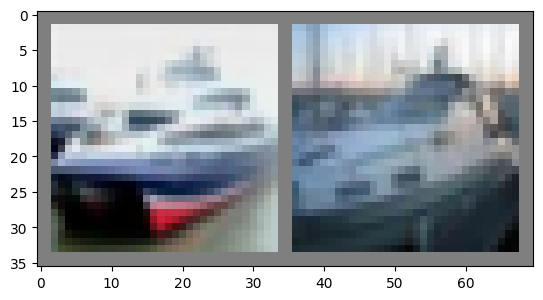

In [91]:
# k closest images:
# get some test image
dataiter = iter(testloader)
images, labels = next(dataiter)
image = images[1:3]
imshow(torchvision.utils.make_grid(image))

In [ ]:
def calculate_nn(image_id):
  """takes in image_id of testset and calculates distances to all images"""
  image, label = testset[image_id]
  image = image.view(1,3,32,32)
  z, _ = model(image) # f(z)
  nn_dict = {}
  tracker = 0
  with torch.no_grad():
      for i in range(len(testset)):  
        test_image, label = testset[i]
        test_image = test_image.view(1,3,32,32)
        z_test, _ = model(test_image) # f(z)
        dist = torch.norm(z_test - z, dim=1, p=None)
        nn_dict[f"{tracker}"] = dist.float()
        tracker += 1
  sorted_nn_dict = sorted(nn_dict.items(), key=lambda kv: kv[1], reverse=False)
  return sorted_nn_dict

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_knn(image_id, k=3):
  """visualizes original image and its k nearest neighbors in the embedding space"""
  sorted_nn_dict = calculate_nn(image_id)
  ls_of_img_tensors = []
  for i in range(k+1):
    id, dist = sorted_nn_dict[i]
    ls_of_img_tensors.append(testset[int(id)])
  img_tensor = torch.stack(ls_of_img_tensors)
  imshow(torchvision.utils.make_grid(img_tensor))

In [ ]:
def calculate_knn_accuracy(k=3, testset=testset):
    true_predicted = 0
    total_predicted = 0
    distance_memory = np.zeros((len(testset), len(testset))) # use dynamic programming

    with torch.no_grad():
        for i in range(len(testset)):
            curr_image, curr_label = testset[i]
            curr_image = curr_image.view(1,3,32,32)
            z_curr, _ = model(curr_image) # f(z)
            for j in range(len(testset)):
                if distance_memory[i][j] == 0: # fill in memory
                    comp_image, comp_label = testset[j]
                    comp_image = comp_image.view(1,3,32,32)
                    z_comp, _ = model(comp_image) # f(z)
                    dist = torch.norm(z_curr - z_comp, dim=1, p=None)
                    distance_memory[i][j] = dist.float()
                else:
                  dist = distance_memory[i][j]

    return distance_memory